# 策略发现1 均值回归：短时间成交价上涨或者下跌超过一定幅度后，必然回调

### 具体例子: 统计1分钟上涨或者下跌超过15个点tick price,在有限制的时间内，发生回调不少于2个tickprice的概率

In [118]:
# -*- coding: utf-8 -*-

%matplotlib inline 

import datetime
import talib
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from numba import *
import numpy as np

mpl.style.use('seaborn-whitegrid')
pd.set_option('display.width', 21250)
pd.set_option('display.max_columns', 21250)
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False


## 获得tick数据

In [119]:

    
def get_tick_csv(tick_file):
    
    print(tick_file)
    df_days_instrument_one_by_one = pd.read_csv(tick_file, header=0,

                                                error_bad_lines=False, low_memory=False,
                                                na_filter=True, verbose=False,
                                                skip_blank_lines=True,
                                                engine='c',
                                                warn_bad_lines=True, chunksize=100000,
                                                iterator=True)
    df = pd.concat(df_days_instrument_one_by_one, ignore_index=True)
    print(df)
    df = df[["logtime", "InstrumentID", "LastPrice", "Volume", "Turnover", "OpenInterest",
             "BidPrice1", "BidVolume1", "AskPrice1", "AskVolume1", "UpdateTime"]]
    
    index = pd.DatetimeIndex(pd.to_datetime(df['logtime'], format="%Y%m%d%H%M%S%f", errors='coerce'))
    df.set_index(index, inplace= True)
    df.index.set_names(['datetime'], inplace=True)
    df.dropna(inplace=True)
    
    return df


In [123]:
#tick_file1 = r'O:\all_tick_instruments\rb1910.csv'
tick_file1 = r'.\rb2001.csv'

tick_df1 = get_tick_csv(tick_file1)


.\rb2001.csv
                 logtime InstrumentID  TradingDay UpdateTime  UpdateMillisec  OpenPrice  HighestPrice  LowestPrice  LastPrice   Volume      Turnover  OpenInterest  AveragePrice  LowerLimitPrice  UpperLimitPrice  BidPrice1  BidVolume1  AskPrice1  AskVolume1
0      20191021113000110       rb2001    20191021   11:30:00               0     3314.0        3321.0       3278.0     3285.0  2282820  7.530251e+10     3377382.0      32986.62           3095.0           3490.0     3285.0           5     3286.0         118
1      20191021113000988       rb2001    20191021   11:30:00             500     3314.0        3321.0       3278.0     3285.0  2282820  7.530251e+10     3377382.0      32986.62           3095.0           3490.0     3285.0           5     3286.0         118
2      20191021133001159       rb2001    20191021   13:30:00             500     3314.0        3321.0       3278.0     3283.0  2284878  7.537011e+10     3377460.0      32986.49           3095.0           3490.0     3

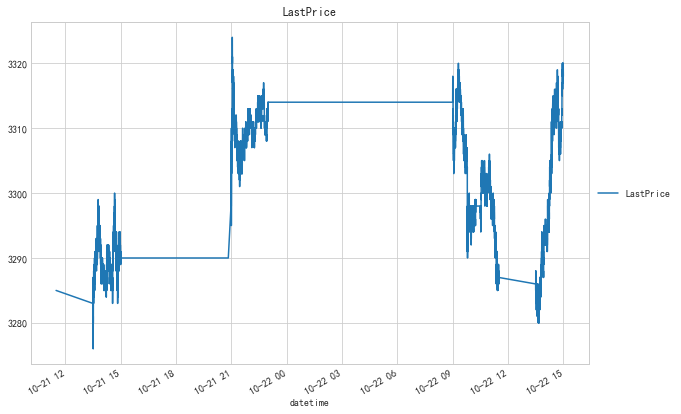

In [124]:
fig,ax=plt.subplots(figsize=(10,7))

tick_df1["LastPrice"].plot(ax=ax, ls='-', label='LastPrice')
ax.set_title('LastPrice')
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

## 把交易按连续性分为多个交易段

In [125]:


def remark_data_time_phase(row):
    if (row.UpdateTime >= "09:00:00" and row.UpdateTime < "10:15:00") \
        or (row.UpdateTime >= "10:30:00" and row.UpdateTime < "11:30:00"):
        return 1

    elif (row.UpdateTime >= "13:30:00" and row.UpdateTime < "15:00:00"):
        return 2
    elif (row.UpdateTime >= "21:00:00" and row.UpdateTime <= "22:59:59"):
        #or (row.UpdateTime >= "00:00:00" and row.UpdateTime <= "02:30:00"):
        return 3
    else:
        return -1


def remark_date_time_by_index(row):
    timeStr = str(row["logtime"])
    dt = datetime.datetime.strptime(timeStr, '%Y%m%d%H%M%S%f')
    log_datetime = int(dt.strftime('%Y%m%d'))
    return log_datetime


def secondofday(time):
    t = time.split(':')
    return int(t[0]) * 3600 + int(t[1]) * 60 + int(t[2])

### 按日期来分段

In [126]:
tick_df1["date_phase"] = tick_df1.apply(remark_date_time_by_index, axis=1)

### 按交易时间来分段

In [127]:
tick_df1["SecondOfDay"] = tick_df1["UpdateTime"].apply(secondofday)

tick_df1["date_time_phase"] = tick_df1.apply(remark_data_time_phase, axis=1)
tick_df1 = tick_df1[tick_df1.date_time_phase > 0]  # only keep valid data


## 此处应当做成循环，按每个时间段处理

In [128]:
# tick_date_phase = tick_df1.groupby(tick_df1["date_phase"])
# for df_phase_date, df_phase_date_ticks in tick_date_phase:
#     #print(df_phase_date, df_phase_date_ticks)
#     df_phase_date_ticks_cp = df_phase_date_ticks#.copy()
#     tick_df1_date_time_phase = df_phase_date_ticks_cp.groupby(df_phase_date_ticks_cp["date_time_phase"])
#     for df_phase_date_time, df_phase_date_time_ticks in tick_df1_date_time_phase:
#         #print("df_phase_date_time,", df_phase_date_time,",df_phase_date_time_ticks: \n",df_phase_date_time_ticks[:1])
#         #todo 本来应该是循环，此处仅适用最后一个时间段
#         tick_df1_one = df_phase_date_time_ticks

# tick_df1_one

In [129]:
tick_df1

,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,UpdateTime,date_phase,SecondOfDay,date_time_phase
datetime,,,,,,,,,,,,,,
2019-10-21 13:30:01.159,20191021133001159,rb2001,3283.0,2284878,7.537011e+10,3377460.0,3284.0,1,3285.0,15,13:30:00,20191021,48600,2
2019-10-21 13:30:02.011,20191021133002011,rb2001,3284.0,2286122,7.541095e+10,3376776.0,3283.0,20,3284.0,2,13:30:01,20191021,48601,2
2019-10-21 13:30:02.038,20191021133002038,rb2001,3283.0,2286288,7.541640e+10,3376854.0,3283.0,27,3284.0,115,13:30:01,20191021,48601,2
2019-10-21 13:30:02.324,20191021133002324,rb2001,3283.0,2286452,7.542178e+10,3376890.0,3282.0,536,3283.0,65,13:30:02,20191021,48602,2
2019-10-21 13:30:02.819,20191021133002819,rb2001,3283.0,2287018,7.544036e+10,3377066.0,3282.0,647,3284.0,94,13:30:02,20191021,48602,2
2019-10-21 13:30:03.529,20191021133003529,rb2001,3283.0,2287368,7.545186e+10,3377246.0,3283.0,51,3284.0,15,13:30:03,20191021,48603,2
2019-10-21 13:30:03.803,20191021133003803,rb2001,3283.0,2287458,7.545481e+10,3377256.0,3283.0,585,3284.0,45,13:30:03,20191021,48603,2
2019-10-21 13:30:04.312,20191021133004312,rb2001,3284.0,2287634,7.546059e+10,3377314.0,3284.0,27,3285.0,161,13:30:04,20191021,48604,2
2019-10-21 13:30:04.809,20191021133004809,rb2001,3283.0,2287800,7.546604e+10,3377342.0,3284.0,79,3285.0,126,13:30:04,20191021,48604,2


In [130]:
tick_df1_one = tick_df1[ (tick_df1["date_time_phase"] == 1) & (tick_df1["date_phase"] == 20191022) ]

### 使用少量数据演示

In [131]:
#df_one = tick_df1_one[:1000]
df_one = tick_df1_one.copy()
print(len(df_one))

16158


### 画图看看

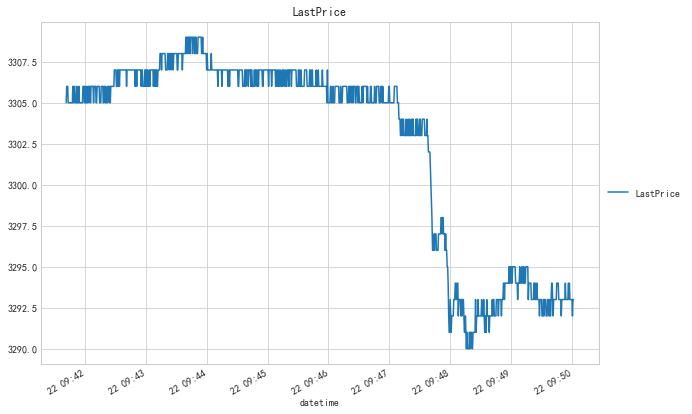

In [132]:
fig,ax=plt.subplots(figsize=(10,7))

df_one[5000:6000]["LastPrice"].plot(ax=ax, ls='-', label='LastPrice')
ax.set_title('LastPrice')
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)
plt.show()

### 统计1分钟上涨或者下跌超过15个点tick price,在有限制的时间内，发生回调不少于2个tickprice的概率

为了简单计算，我们以连续tick数量来做统计，比如，假设500ms一个tick, 1分钟就有 60乘以2 = 120个tick。统计一分钟，就近似等于120个tick。等待15秒，就是等待15乘以 2 = 30个tick

<font color="red">注意</font> 如果成交不活跃，连续几秒没有成交或者askVolume，bidVolume没有变动，那就会一直没有tick到达。


### Ask Bid 挂单中间价， 价差

In [133]:
df_one["mid_price"] = (df_one['BidPrice1'] + df_one['AskPrice1']) / 2
df_one["dmid_price"] = df_one["mid_price"].diff().fillna(0)

### 打印"急速上升"出现的起点的位置， 使用未来函数 shift(-i)

In [134]:
i = 120
#找到最大值
df_one["mid_price_roll_max"] = df_one["mid_price"].rolling(i).max()
df_one["mid_price_roll_min"] = df_one["mid_price"].rolling(i).min()
# 最大值前移，减去当前值，就是以后的上升值
df_one["mid_price_diff_max"] = df_one["mid_price_roll_max"].shift(-i) - df_one["mid_price"]
df_one["mid_price_diff_min"] = df_one["mid_price_roll_min"].shift(-i) - df_one["mid_price"]
# 取出本段数据的极值
max_value = df_one["mid_price_diff_max"].max()
min_value = df_one["mid_price_diff_min"].min()
print("mid_price_diff_max" + str(i) + " :", max_value , min_value)
# 找到最值的发生位置
find_max_index = np.where(df_one["mid_price_diff_max"].values == max_value)
find_min_index = np.where(df_one["mid_price_diff_min"].values == min_value)

print(df_one.iloc[find_max_index][["mid_price","mid_price_diff_max","mid_price_diff_min"] ] )
print(df_one.iloc[find_min_index][["mid_price","mid_price_diff_max","mid_price_diff_min"] ] )

mid_price_diff_max120 : 6.0 -14.0
                         mid_price  mid_price_diff_max  mid_price_diff_min
datetime                                                                  
2019-10-22 09:10:10.029     3309.5                 6.0                 0.0
2019-10-22 09:10:10.530     3309.5                 6.0                 1.0
2019-10-22 09:50:03.038     3291.5                 6.0                 0.0
2019-10-22 09:50:03.558     3291.5                 6.0                 0.0
2019-10-22 09:50:04.040     3291.5                 6.0                 0.0
2019-10-22 09:50:04.540     3291.5                 6.0                 0.0
2019-10-22 09:50:05.052     3291.5                 6.0                 0.0
2019-10-22 09:50:05.555     3291.5                 6.0                 0.5
                         mid_price  mid_price_diff_max  mid_price_diff_min
datetime                                                                  
2019-10-22 09:46:59.040     3305.5                 0.0            

In [135]:
print(find_max_index[0])
find_max_index_end = find_max_index[0] + i
print(find_max_index_end)

[1218 1219 6002 6003 6004 6005 6006 6007]
[1338 1339 6122 6123 6124 6125 6126 6127]


In [136]:
df_one.iloc[find_max_index]["mid_price"]

datetime
2019-10-22 09:10:10.029    3309.5
2019-10-22 09:10:10.530    3309.5
2019-10-22 09:50:03.038    3291.5
2019-10-22 09:50:03.558    3291.5
2019-10-22 09:50:04.040    3291.5
2019-10-22 09:50:04.540    3291.5
2019-10-22 09:50:05.052    3291.5
2019-10-22 09:50:05.555    3291.5
Name: mid_price, dtype: float64

In [137]:
df_one.iloc[find_max_index_end]["mid_price"]

datetime
2019-10-22 09:11:10.201    3315.5
2019-10-22 09:11:10.535    3315.5
2019-10-22 09:51:03.045    3297.5
2019-10-22 09:51:03.544    3297.5
2019-10-22 09:51:04.036    3297.5
2019-10-22 09:51:04.552    3296.5
2019-10-22 09:51:05.048    3296.5
2019-10-22 09:51:05.558    3296.5
Name: mid_price, dtype: float64

In [138]:
len(df_one)

16158

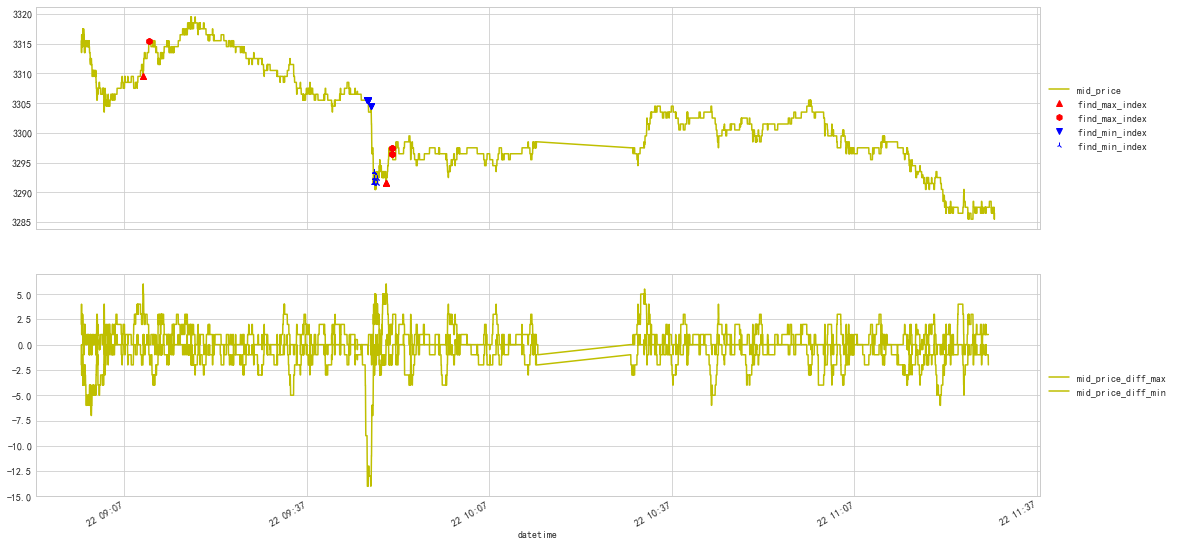

In [139]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

df_one["mid_price"].plot(ax=ax[0], ls='-', color='y', label='mid_price')

df_one.iloc[find_max_index]["mid_price"].plot(ax=ax[0], color='r', marker='^', linestyle='None', label='find_max_index')
df_one.iloc[find_max_index[0] + i]["mid_price"].plot(ax=ax[0], color='r', marker='h', linestyle='None', label='find_max_index')

df_one.iloc[find_min_index]["mid_price"].plot(ax=ax[0], color='b', marker='v', linestyle='None', label='find_min_index')
df_one.iloc[find_min_index[0] + i]["mid_price"].plot(ax=ax[0], color='b', marker='2', linestyle='None', label='find_min_index')

ax[0].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

df_one["mid_price_diff_max"].plot(ax=ax[1], ls='-', color='y', label='mid_price_diff_max')
df_one["mid_price_diff_min"].plot(ax=ax[1], ls='-', color='y', label='mid_price_diff_min')
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

plt.show()

打印的的都是极值出现之前的启动点位

### 收集急速上升和急速下降的数据, n 分钟出现的极大值，极小值 p，出现极值后的回调点位 p

In [140]:
#最大1,2,3,4,5分钟的连续增长数据
ranges = list(np.array(range(60*2, 60*2*6, 120)))

print(ranges)
#ts = pd.Series(ranges)

[120, 240, 360, 480, 600]


In [141]:
def cal_max_direction_and_reverse(instrumentID, idx, next_reverse_tick_number):
    i = int(idx)
    # 一定idx之后的，价格和现在价格的差值
    df_one["mid_price_roll_max"] = df_one["mid_price"].rolling(i).max()
    df_one["mid_price_roll_min"] = df_one["mid_price"].rolling(i).min()
    # 取最大最小
    df_one["mid_price_diff_max"] = df_one["mid_price_roll_max"].shift(-i) - df_one["mid_price"]
    df_one["mid_price_diff_min"] = df_one["mid_price_roll_min"].shift(-i) - df_one["mid_price"]
    
    max_value = df_one["mid_price_diff_max"].max()
    min_value = df_one["mid_price_diff_min"].min()
    #print("mid_price_diff_max" + str(i) + " :", max_value , min_value)
    # 找到最大值的发生位置
    find_max_index = np.where(df_one["mid_price_diff_max"].values == max_value)
    #print("max index", find_index[0])
    touched_index = 0
    # 遍历起始位start_idx, 找到的上升或者下降最大值位置是 start_idx + i
    # 之后从  start_idx + i 到start_idx + i+ next_reverse_tick_number 看回调的位置
    for start_idx in find_max_index[0]:
        #如果数据足够
        #print("start_idx:", start_idx)
        #print("len(df_one):", len(df_one))
        if start_idx < touched_index:
            continue
        if start_idx + i + next_reverse_tick_number < len(df_one):
            # 计算回归的时候使用, next_reverse_tick_number以后的价格，减去现在价格
            #print("start_idx:", start_idx, " end:", start_idx + next_reverse_tick_number)
            #print(df_one[start_idx+ i: start_idx + i+ next_reverse_tick_number][["mid_price", "mid_price_diff_max", "mid_price_diff_min"]] )
            mid_price_reverse = df_one[start_idx + i: start_idx + i + next_reverse_tick_number]["mid_price"] - df_one[start_idx + i: start_idx + i + 1]["mid_price"].values[0]
            touched_index = start_idx + next_reverse_tick_number
            print(instrumentID,",",df_one[start_idx:start_idx+1].index[0],",tick_numbers,",idx,",wait_tick_numbers,",next_reverse_tick_number ,",max_value,", max_value,",goon_up," ,mid_price_reverse.max(), ",reverse_down," ,mid_price_reverse.min())
            
            
    # 找到最小值的发生位置
    find_min_index = np.where(df_one["mid_price_diff_min"].values == min_value)
    #print("max index", find_min_index[0])
    touched_index = 0
    # 遍历起始位
    for start_idx in find_min_index[0]:
        #如果数据足够
        #print("start_idx:", start_idx)
        #print("len(df_one):", len(df_one))
        if start_idx < touched_index:
            continue
        if start_idx + i + next_reverse_tick_number < len(df_one):
            # 计算回归的时候使用, next_reverse_tick_number以后的价格，减去现在价格
            #print("start_idx:", start_idx, " end:", start_idx + next_reverse_tick_number)
            #print(df_one[start_idx + i: start_idx + i + next_reverse_tick_number][["mid_price", "mid_price_diff_max", "mid_price_diff_min"]] )
            mid_price_reverse = df_one[start_idx + i: start_idx + i + next_reverse_tick_number]["mid_price"] - df_one[start_idx + i: start_idx + i + 1]["mid_price"].values[0]
            touched_index = start_idx + next_reverse_tick_number
            print(instrumentID,",",df_one[start_idx:start_idx+1].index[0],",tick_numbers,",idx,",wait_tick_numbers,",next_reverse_tick_number ,",min_value,", min_value,",goon_down," ,mid_price_reverse.min(), ",reverse_up," ,mid_price_reverse.max())


In [142]:
next_reverse_tick_number = 60*2*5
instrumentID = "rb2001"

plt.figure(1, figsize=(20,10))

for idx in ranges:
#for idx in [120]:
    i = int(idx)
    cal_max_direction_and_reverse(instrumentID, idx, next_reverse_tick_number)
    
#df_one.dropna(inplace=True)
#print(df_one.columns)

rb2001 , 2019-10-22 09:10:10.029000 ,tick_numbers, 120 ,wait_tick_numbers, 600 ,max_value, 6.0 ,goon_up, 0.0 ,reverse_down, -4.0
rb2001 , 2019-10-22 09:50:03.038000 ,tick_numbers, 120 ,wait_tick_numbers, 600 ,max_value, 6.0 ,goon_up, 2.0 ,reverse_down, -3.0
rb2001 , 2019-10-22 09:46:59.040000 ,tick_numbers, 120 ,wait_tick_numbers, 600 ,min_value, -14.0 ,goon_down, -1.0 ,reverse_up, 7.0
rb2001 , 2019-10-22 09:09:10.526000 ,tick_numbers, 240 ,wait_tick_numbers, 600 ,max_value, 8.0 ,goon_up, 0.0 ,reverse_down, -4.0
rb2001 , 2019-10-22 10:31:25.041000 ,tick_numbers, 240 ,wait_tick_numbers, 600 ,max_value, 8.0 ,goon_up, 3.0 ,reverse_down, -1.0
rb2001 , 2019-10-22 09:46:14.558000 ,tick_numbers, 240 ,wait_tick_numbers, 600 ,min_value, -15.0 ,goon_down, 0.0 ,reverse_up, 8.0
rb2001 , 2019-10-22 10:31:25.041000 ,tick_numbers, 360 ,wait_tick_numbers, 600 ,max_value, 10.0 ,goon_up, 1.0 ,reverse_down, -3.0
rb2001 , 2019-10-22 09:45:21.043000 ,tick_numbers, 360 ,wait_tick_numbers, 600 ,min_value, -1

<Figure size 1440x720 with 0 Axes>

# 制作程序进行大量历史统计。然后根据统计结果，设计策略

In [143]:

original_columns_def = ['InstrumentID', 'datetime',
                        'tick_numbersStr', 'tick_numbers',
                        'wait_tick_numbersStr', 'wait_tick_numbers',
                        'max_valueStr', 'max_value',
                        'goon_upStr', 'goon_up',
                        'reverse_downStr', 'reverse_down']

csv = pd.read_csv(r"C:\Anaconda3\Scripts\fintech\mean_reverse_rb.csv", header=None, names=original_columns_def)
print(csv.head(5))
print(csv.columns)

  InstrumentID                      datetime tick_numbersStr  tick_numbers wait_tick_numbersStr  wait_tick_numbers max_valueStr max_value goon_upStr  goon_up reverse_downStr  reverse_down
0      rb1201           2011-12-29 09:29:58     tick_numbers           240    wait_tick_numbers                600    max_value      12.5    goon_up      2.5    reverse_down         -52.5
1      rb1201    2011-12-29 09:00:00.500000     tick_numbers           480    wait_tick_numbers                600    min_value       -57  goon_down    -39.0      reverse_up           9.0
2      rb1201    2011-12-29 09:00:00.500000     tick_numbers           600    wait_tick_numbers                600    min_value       -57  goon_down    -53.0      reverse_up           2.5
3      rb1201    2011-12-30 09:28:06.500000     tick_numbers           120    wait_tick_numbers                600    max_value      38.5    goon_up      4.5    reverse_down         -23.0
4      rb1201    2011-12-30 09:19:32.500000     tick_numbers

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 看上涨之后，回调的量

In [144]:
csv["reverse_down"] = csv["reverse_down"].astype("float")
csv["max_value"] = csv["max_value"].astype("float")

In [145]:
print(csv[csv.max_valueStr =='max_value']["max_value"].max())
print(csv[csv.max_valueStr =='max_value']["max_value"].min())

8.988450000000039e+307
1.0


In [146]:
## 过滤掉脏tick数据
csv = csv[csv.max_value < 1000]

In [147]:
print(csv[csv.max_valueStr =='max_value']["max_value"].max())
print(csv[csv.max_valueStr =='max_value']["max_value"].min())

320.0
1.0


In [148]:
max_csv = csv[csv.max_valueStr =='max_value']

### 查看一下观察时间 120个tick的数据

InstrumentID            0.189096
datetime                0.189096
tick_numbersStr         0.189096
tick_numbers            0.189096
wait_tick_numbersStr    0.189096
wait_tick_numbers       0.189096
max_valueStr            0.189096
max_value               0.189096
goon_upStr              0.189096
goon_up                 0.189096
reverse_downStr         0.189096
reverse_down            0.189096
dtype: float64


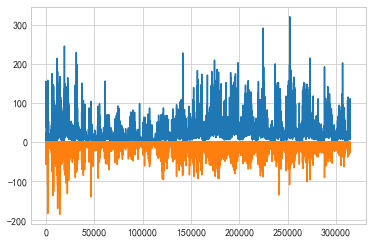

In [149]:
max_csv_tickn = max_csv[max_csv.tick_numbers == 120]
# > -3 ==  -2, -1  , 0
print(max_csv_tickn[max_csv_tickn.reverse_down > -3].count()/ max_csv_tickn.count())

max_csv_tickn["max_value"].plot()
max_csv_tickn["reverse_down"].plot()

### 19% 个回调小于3个tick price, 也就是说  81%的回调会大于 3个tick price, 如果在连续上升到“高位”（此处高位是多少未知）开仓的话，平均会有81%的机会盈利1~2个点位。

1.0      0.003145
1.5      0.000113
2.0      0.017824
2.5      0.000170
3.0      0.026779
3.5      0.001247
4.0      0.032475
4.5      0.003174
5.0      0.033665
5.5      0.005497
6.0      0.034742
6.5      0.007651
7.0      0.036414
7.5      0.008813
8.0      0.035875
8.5      0.009748
9.0      0.033467
9.5      0.011250
10.0     0.029754
10.5     0.010768
11.0     0.023492
11.5     0.011448
12.0     0.023435
12.5     0.010145
13.0     0.019099
13.5     0.009890
14.0     0.016181
14.5     0.009918
15.0     0.014424
15.5     0.010201
           ...   
166.5    0.000028
167.0    0.000057
171.0    0.000028
171.5    0.000028
173.0    0.000028
174.0    0.000028
175.0    0.000028
176.5    0.000028
177.5    0.000028
178.5    0.000028
180.0    0.000085
182.5    0.000028
183.0    0.000028
185.5    0.000028
190.5    0.000028
191.0    0.000028
192.0    0.000028
197.5    0.000057
198.5    0.000028
199.5    0.000028
202.0    0.000028
202.5    0.000028
209.0    0.000028
214.0    0.000028
214.5    0

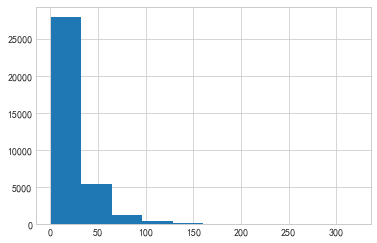

In [150]:
### 这段时间连续上升多少的分步
print(max_csv_tickn["max_value"].value_counts(normalize=True).sort_index() )

print(max_csv_tickn["max_value"].value_counts().sort_index() )
max_csv_tickn["max_value"].hist()

### 继续上升的统计

0.0      0.161268
0.5      0.027204
1.0      0.087591
1.5      0.023718
2.0      0.064751
2.5      0.021366
3.0      0.049364
3.5      0.020856
4.0      0.038766
4.5      0.018221
5.0      0.032560
5.5      0.017201
6.0      0.026439
6.5      0.016804
7.0      0.021395
7.5      0.014820
8.0      0.021168
8.5      0.013545
9.0      0.018164
9.5      0.012553
10.0     0.015699
10.5     0.012752
11.0     0.014027
11.5     0.012100
12.0     0.012383
12.5     0.009890
13.0     0.011817
13.5     0.009068
14.0     0.010825
14.5     0.009493
           ...   
66.5     0.000057
67.5     0.000057
68.0     0.000113
68.5     0.000028
69.0     0.000057
70.0     0.000028
71.0     0.000057
72.0     0.000028
73.0     0.000028
73.5     0.000057
74.5     0.000028
75.0     0.000028
78.0     0.000028
80.0     0.000028
80.5     0.000028
81.5     0.000057
84.5     0.000028
85.0     0.000085
85.5     0.000028
87.0     0.000028
92.0     0.000028
94.0     0.000028
94.5     0.000057
95.0     0.000028
95.5     0

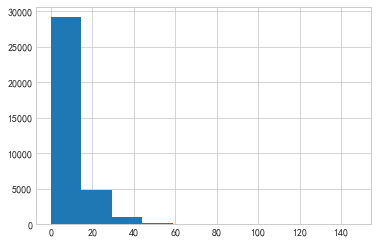

In [151]:
print(max_csv_tickn["goon_up"].value_counts(normalize=True).sort_index() )

print(max_csv_tickn["goon_up"].value_counts().sort_index() )
max_csv_tickn["goon_up"].hist()

### 连续上升10个tick price以后，回调大于 3个tick price （ < -3 == -4, -5, -6 -7....） 的占比

In [152]:
print(max_csv_tickn[(max_csv_tickn.max_value > 10) & (max_csv_tickn.reverse_down < -3)].count()/ max_csv_tickn[max_csv_tickn.max_value > 10].count())

InstrumentID            0.883461
datetime                0.883461
tick_numbersStr         0.883461
tick_numbers            0.883461
wait_tick_numbersStr    0.883461
wait_tick_numbers       0.883461
max_valueStr            0.883461
max_value               0.883461
goon_upStr              0.883461
goon_up                 0.883461
reverse_downStr         0.883461
reverse_down            0.883461
dtype: float64


### 连续上升10个tick price以后，继续上升5个tick price 的占比

In [153]:
print(max_csv_tickn[(max_csv_tickn.max_value > 10) & (max_csv_tickn.goon_up > 5)].count()/ max_csv_tickn[max_csv_tickn.max_value > 10].count())

InstrumentID            0.620611
datetime                0.620611
tick_numbersStr         0.620611
tick_numbers            0.620611
wait_tick_numbersStr    0.620611
wait_tick_numbers       0.620611
max_valueStr            0.620611
max_value               0.620611
goon_upStr              0.620611
goon_up                 0.620611
reverse_downStr         0.620611
reverse_down            0.620611
dtype: float64


### <font color="red">注意：</font>出现这个统计结果的原因，是我们没有规定谁先谁后出现，很有可能是发生一定程度的回调（reverse_down）以后，又继续拉升（goon_up）了

不过，您有没有发现？在连续上升10个 tickprice， 之后，继续上升5个 tick price的机会，竟然达到 62%？  我们可以据此开发一个“趋势跟踪系统”, 和我们的均值回归策略，进行互补。

### 写一个简单的策略

In [188]:
i = 120
#找到最大值
df_one["mid_price_roll_max"] = df_one["mid_price"].rolling(i).max()
df_one["mid_price_roll_min"] = df_one["mid_price"].rolling(i).min()

# 当前值减去 历史 高价, 下跌了多少
df_one["mid_price_diff_min"] = df_one["mid_price"] - df_one["mid_price_roll_max"]
# 当前值减去 历史 低价, 上涨了多少
df_one["mid_price_diff_max"] = df_one["mid_price"] - df_one["mid_price_roll_min"]
df_one

,logtime,InstrumentID,LastPrice,Volume,Turnover,OpenInterest,BidPrice1,BidVolume1,AskPrice1,AskVolume1,UpdateTime,date_phase,SecondOfDay,date_time_phase,mid_price,dmid_price,mid_price_roll_max,mid_price_roll_min,mid_price_diff_max,mid_price_diff_min
datetime,,,,,,,,,,,,,,,,,,,,
2019-10-22 09:01:59.553,20191022090159553,rb2001,3311.0,969820,3.210753e+10,3371260.0,3310.0,188,3311.0,353,09:01:59,20191022,32519,1,3310.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:00.031,20191022090200031,rb2001,3310.0,969838,3.210812e+10,3371266.0,3310.0,231,3311.0,479,09:02:00,20191022,32520,1,3310.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:00.538,20191022090200538,rb2001,3310.0,970514,3.213050e+10,3371088.0,3309.0,524,3310.0,16,09:02:00,20191022,32520,1,3309.5,-1.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:01.046,20191022090201046,rb2001,3310.0,970566,3.213222e+10,3371110.0,3309.0,562,3310.0,36,09:02:01,20191022,32521,1,3309.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:01.543,20191022090201543,rb2001,3310.0,971028,3.214751e+10,3371308.0,3310.0,20,3311.0,548,09:02:01,20191022,32521,1,3310.5,1.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:02.027,20191022090202027,rb2001,3310.0,971134,3.215102e+10,3371324.0,3310.0,40,3311.0,616,09:02:02,20191022,32522,1,3310.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:02.549,20191022090202549,rb2001,3310.0,971182,3.215261e+10,3371332.0,3310.0,30,3311.0,639,09:02:02,20191022,32522,1,3310.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:03.048,20191022090203048,rb2001,3310.0,971234,3.215433e+10,3371378.0,3310.0,30,3311.0,637,09:02:03,20191022,32523,1,3310.5,0.0,NaN,NaN,NaN,NaN
2019-10-22 09:02:03.546,20191022090203546,rb2001,3310.0,971298,3.215645e+10,3371438.0,3309.0,655,3310.0,13,09:02:03,20191022,32523,1,3309.5,-1.0,NaN,NaN,NaN,NaN


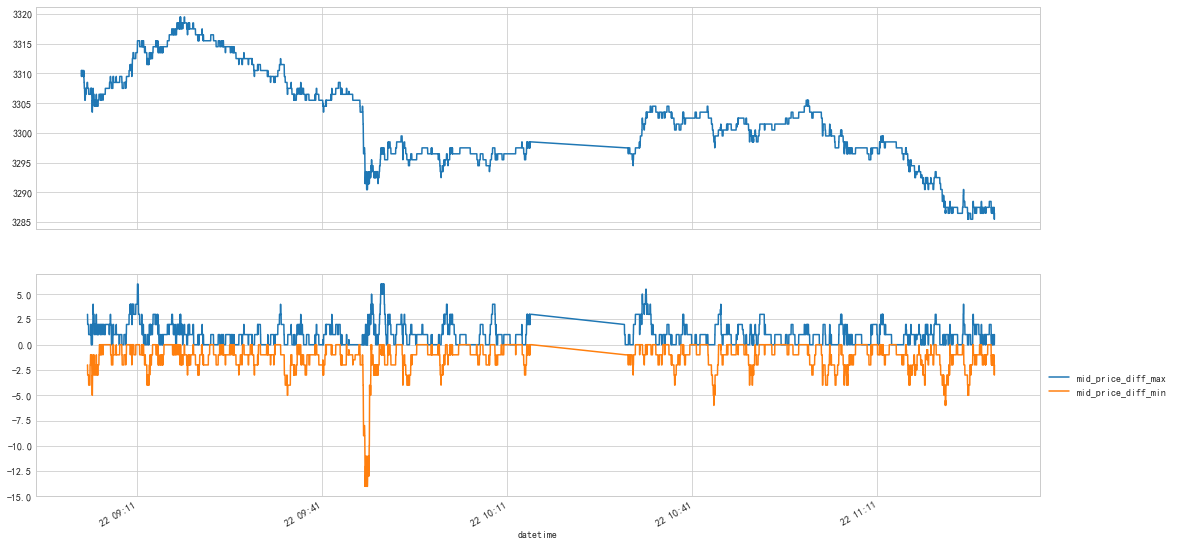

In [189]:
fig, ax = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

df_one["mid_price"].plot(ax=ax[0], ls='-', label='mid_price')

df_one["mid_price_diff_max"].plot(ax=ax[1], ls='-',  label='mid_price_diff_max')
df_one["mid_price_diff_min"].plot(ax=ax[1], ls='-',  label='mid_price_diff_min')
ax[1].legend(loc="center left", bbox_to_anchor=(1.0, 0.5), numpoints=1)

plt.show()

In [184]:
df_one.dropna(inplace=True)

### 本阶段数据 最大连续下降

In [190]:
df_one["mid_price_diff_max"].max()

6.0

### 本阶段数据 最大连续上升

In [191]:
df_one["mid_price_diff_min"].min()

-14.0

### 上升回调的策略。上升6个tick price后开仓，对价成交，盈利2个tick price平仓, 也是对价成交。止损5个tick price

In [192]:
contract_multiplier = 10
up_threshold = 6
down_threshold = -14
next_reverse_tick_number = 60*2*5
instrumentID = "rb2001"
# 2个tick price 止盈
TP = 2
# 5个tick price 止损
TL = 5

TR_COST = 3.6 #未按货币合约乘数总价值计算手续费
pos = 0
pnl = 0
trade_costs = 0
buy_price = 0
sell_price = 0

trade_volume = 0
trade_records = []
total_trade_pnl = []


length_of_data = len(df_one)

for i in range(length_of_data):
    #print(df_one["mid_price_diff_max"][i])
    # 没有仓位，并且上升超过限制，进行开仓
    if df_one["mid_price_diff_max"][i] >= up_threshold and 0 == pos:
        sell_price = df_one["BidPrice1"][i] # 对价开仓
        pos = -1
        tc = TR_COST  
        trade_costs = trade_costs + tc
        trade_volume = trade_volume + 1
        trade_records.append((instrumentID, str(df_one.index[i]), 'SELL', 1, sell_price, tc, 0))
        print(instrumentID, str(df_one.index[i]), 'SELL', 1, sell_price, tc, 0)
    if df_one["mid_price_diff_max"][i] <= -down_threshold and pos == 0:
        pass
    elif pos != 0:
        if pos == -1:
            # 止盈 或者 止损
            buy_price =  df_one["AskPrice1"][i] # 对价平仓
            if buy_price >= sell_price + TL or buy_price <= sell_price - TP:
                pos = 0
                
                tc = TR_COST
                trade_costs = trade_costs + tc
                trade_pnl = contract_multiplier *(sell_price - buy_price) -  2*tc
                pnl = pnl + trade_pnl
                trade_volume = trade_volume + 1
                total_trade_pnl.append(trade_pnl)
                trade_records.append((instrumentID, str(df_one.index[i]), 'BUY', 1, buy_price, tc, trade_pnl))
                print(instrumentID, str(df_one.index[i]), 'BUY', 1, buy_price, tc, trade_pnl)
            
        elif pos == 1:
            pass
    if i + next_reverse_tick_number > length_of_data and pos != 0:
        #如果到最后还没平仓，强制平仓
        if pos == -1:
            # 止盈 或者 止损
            buy_price =  df_one["AskPrice1"][i]

            pos = 0

            tc = TR_COST
            trade_costs = trade_costs + tc
            trade_pnl = contract_multiplier *(sell_price - buy_price) -  2*tc
            pnl = pnl + trade_pnl
            trade_volume = trade_volume + 1
            total_trade_pnl.append(trade_pnl)
            trade_records.append((instrumentID, str(df_one.index[i]), 'BUY', 1, buy_price, tc, trade_pnl))
            print(instrumentID, str(df_one.index[i]), 'BUY', 1, buy_price, tc, trade_pnl)
        break

print(trade_volume)
print(pnl)

rb2001 2019-10-22 09:11:05.540000 SELL 1 3315.0 3.6 0
rb2001 2019-10-22 09:12:36.049000 BUY 1 3313.0 3.6 12.8
rb2001 2019-10-22 09:50:31.552000 SELL 1 3297.0 3.6 0
rb2001 2019-10-22 09:55:00.060000 BUY 1 3295.0 3.6 12.8
4
25.6


### 百尺竿头更进一步: 按星期几分类统计; 按上午下午，夜晚分类统计......

In [ ]:
work forward
[1,2,3] ->result ->choose parameter-> [4,5] -- Yes/No ->>[4,5,6] ->result ->choose parameter-> [7,8] -- Yes/No